In [75]:
# library imports
from importlib import reload
from copy import deepcopy
from Classes import ClusterObj, BlockObj, ScanDataObj
from Functions import CommonFunctions, ClassesFunctions
import pickle
import pandas as pd
import re
reload(CommonFunctions)
reload(ClassesFunctions)
reload(ClusterObj)
reload(BlockObj)
reload(ScanDataObj)

print('Done!')


Done!


In [76]:
# path setup
path = "/Users/afarinaqs/Library/CloudStorage/Box-Box/Home Folder aa714/Private/BME LAB/Afi/OOD Detection/Data/Ag Test"
input_file_name = '05062025_P0428_OF_first_slide_N5'
image, scaled_image = CommonFunctions.load_image(file_name=input_file_name, path=path, debug=False, plot_images=False, rotation=0)
# print(f'Loaded Image "{input_file_name}" {image.shape}')


In [77]:
# load the saved work, or start over:
scan_data = ClassesFunctions.read_scan_data_from_pickle(
    file_name=input_file_name,
    path=path,
    start_over=0, # if True -> ignores the pickle, and returns None for initiating with the following functions
    plot_results=False,
    debug=False
)

# scan_data = []
if not scan_data:
    start_over = True
else:
    print(f'Successfully loaded scan_data for "{input_file_name}"')
    start_over = False



Successfully loaded scan_data for "05062025_P0428_OF_first_slide_N5"


In [78]:
# todo: add a function for parameter tuning...
start_over

False

In [79]:
## Setting the parameters:
# start_over = True
do_test = 1
input_param_dict = {
    'scan_size': 5, 'assay': 'OF', 'cAb_names': [],
    'blur_kernel_size': 11, 'contrast_thr': 200, # preprocessing
    'canny_edge_thr1': 90, 'canny_edge_thr2': 290, 'dp': 1.6, 'param1': 11, 'param2':22, 'minRadius': 11, 'maxRadius': 18, # circle finding
    'eps':500, 'x_power': 3, 'y_power': 5, 'min_samples': 3 # clustering
}

# reset = True/False to overwrite start_over
if start_over:
    ScanDataObj.init_or_reset_params(file_name=input_file_name, input_param_dict=input_param_dict, debug=False)
    if do_test:
        if input_param_dict['assay'] == 'SD4':
            test_image = deepcopy(image)[1000:1700,500:2500] #(y,x) -> change if u want!
        else:
            test_image = deepcopy(image)[500:1400,50:2600]
        # checkme takes too long
        # CommonFunctions.optimize_the_params(file_name=input_file_name, input_image=test_image, how_many_times=1, plot_images=False, debug=False)
        CommonFunctions.test_current_parameters(input_image=test_image, file_name=input_file_name, fig_size=[12,7], debug=False)

In [80]:
scan_data = ScanDataObj.get_scan_data(file_name=input_file_name)

In [81]:
# start_over=True
if start_over or not scan_data.sorted_circles:
    CommonFunctions.do_initial_circle_finding(file_name=input_file_name, debug=False, plot_images=False)
    ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
# else:
#     sorted_circles, predicted_clusters_ids = [],[]

In [82]:
# start_over = True
test_block_sizes = 1

if start_over:
    ClassesFunctions.init_blocks_dict(
        file_name=input_file_name, debug=False, plot_blocks=False,
        # debug_block_ids=['r0c0','r0c1','r0c2','r0c3'],
        init_offset=[0,0],
        block_size_adjustment=0,
        block_distance_adjustment=[0,-20],
    )
    if test_block_sizes:
        ClassesFunctions.plot_blocks_on_image(file_name=input_file_name, debug=False)
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

In [83]:
# ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

In [84]:
# start_over = True
if start_over:
    ClassesFunctions.init_clusters_dict(scan_data.sorted_circles, scan_data.predicted_clusters_ids, input_file_name,
                                        optimize_spots_coords=1, debug=0, debug_clusters_ids=[])
    ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

In [85]:
# connect clusters and blocks (and final initiation stuff)
if start_over:
    ClassesFunctions.connect_clusters_to_blocks(file_name=input_file_name,debug=False,debug_clusters=[],debug_blocks=[],plot_images=False,)
    ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

In [86]:
# test_block.__dict__

In [87]:
# scan_data.get_cluster(838)

[0, 1, 2, 4, 5, 8, 9, 14, 18, 22, 23, 219, 220, 221]

 

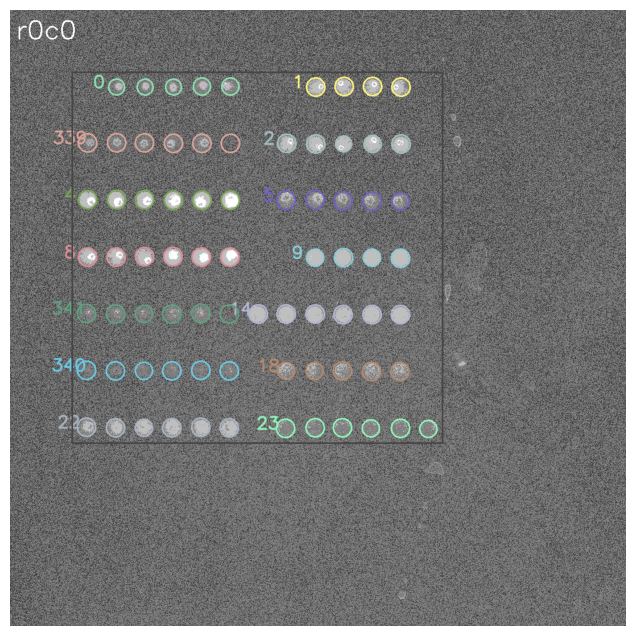

There are 14 clusters in total.


In [88]:
## Making the first template of cluster patterns
start_over=True

test_ind = f'r0c0'
test_block: BlockObj.Block = scan_data.get_block(test_ind)
if not start_over:
    test_block.plot_block(fig_size=[6, 6], debug=False, with_border=True, crop_to_mask=True)
else:
    scan_data = ScanDataObj.get_scan_data(file_name=input_file_name)
    manual_spot_edit_dict = {
        0: ['add 2 to l'],
        4:['add 1 cluster above d=100'],
        22: ['add 2 clusters above d=100'],
        14:['move spot1 1 u , 1 l','move spot3 1 d', 'move spot-2 1 d'],
        219:['del spot-1'],
        221:['del spot-1'],
        23:['change_r spot-2 r-2','move spot-2 2 u']
    }
    print(test_block.clusters_ids_list)
    test_block.edit_block(debug=0, plot_before_after=False, overwrite=True,with_restore=True,
                          manual_spot_edit_dict=manual_spot_edit_dict)
    test_mask = test_block.create_block_mask(debug=False, plot_images=False)
    test_block.plot_block(fig_size=[8,8], debug=False, with_border=True, crop_to_mask=False)

N = len(test_block.clusters_ids_list)
print(f'There are {N} clusters in total.')


In [89]:
# generating the list to edit each row at the same time
generate_list = lambda n: [f'r{n}c{i}' for i in range(scan_data.block_ncol)]
rows_names_list = []
for r in range(scan_data.block_nrow):
    rows_names_list.append(generate_list(r))


fig_size = [20,10] if scan_data.assay == 'SD4' else [15,15]
print(f'start_over is {start_over}')


start_over is True


In [90]:
# ScanDataObj.get_block_image(
#             file_name=test_block.file_name,
#             block_id=test_block.block_id,
#             image_tag='block_mask'
#         )
plot_figures = False
ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

['r0c0', 'r0c1', 'r0c2']

 

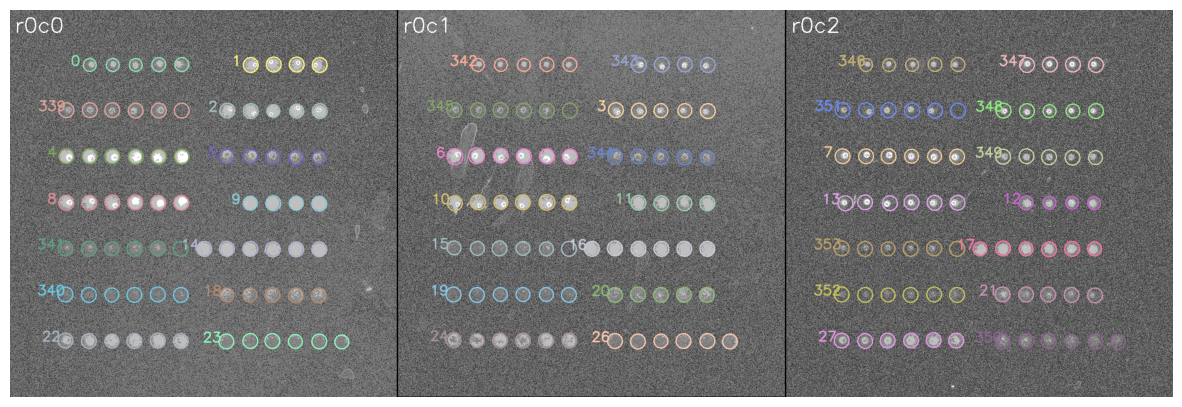

In [91]:
# row 0
r = 0
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={'r0c0':[0,0],'r0c1':[0,0],'r0c2':[0,0],'r0c3':[0,0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
        })

['r1c0', 'r1c1', 'r1c2']

 

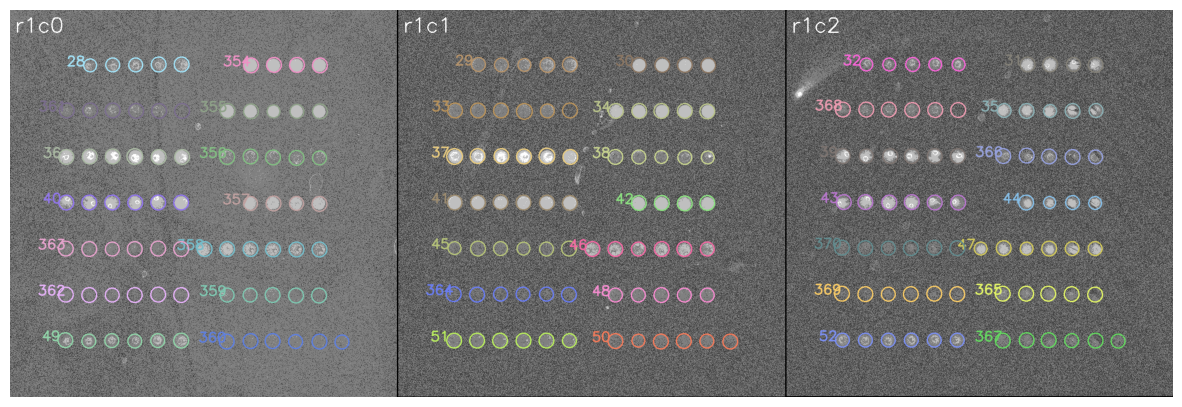

In [92]:
## row 1
r = 1
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0':[0,0],f'r{r}c1':[0,0],f'r{r}c2':[0,0],f'r{r}c3':[0,0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
        })

['r2c0', 'r2c1', 'r2c2']

 

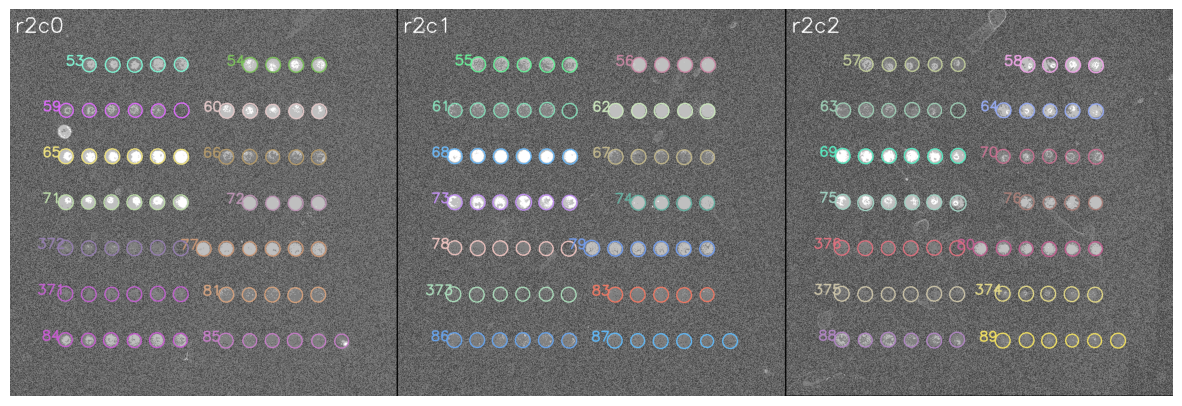

In [93]:
# row 2
r = 2
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0':[0,0],f'r{r}c1':[0,0],f'r{r}c2':[0,0],f'r{r}c3':[0,0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
        })

In [94]:
# scan_data.get_block('r3c0').plot_block()

['r3c0', 'r3c1', 'r3c2']

 

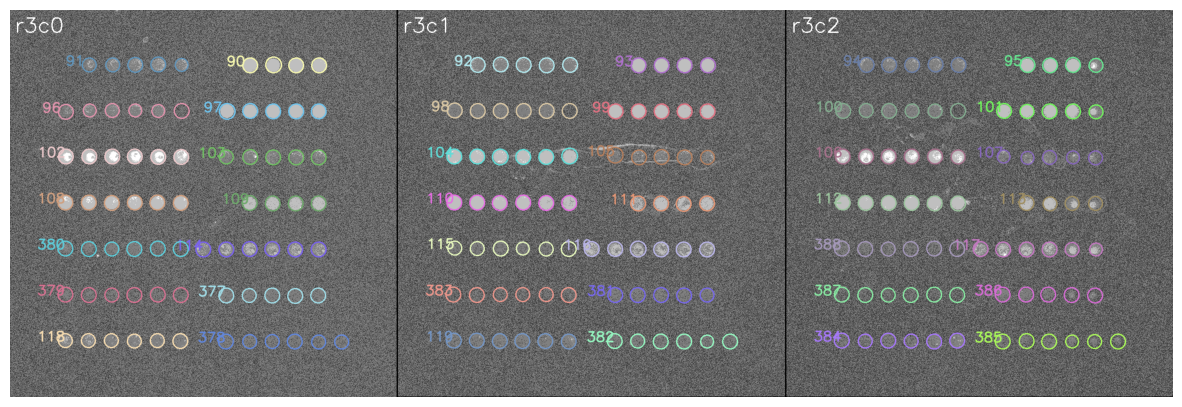

In [95]:
# row 3
r = 3
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, do_plot=1)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0':[0,0],f'r{r}c1':[0,0],f'r{r}c2':[0,0],f'r{r}c3':[0,0]},
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
        })


['r4c0', 'r4c1', 'r4c2']

 

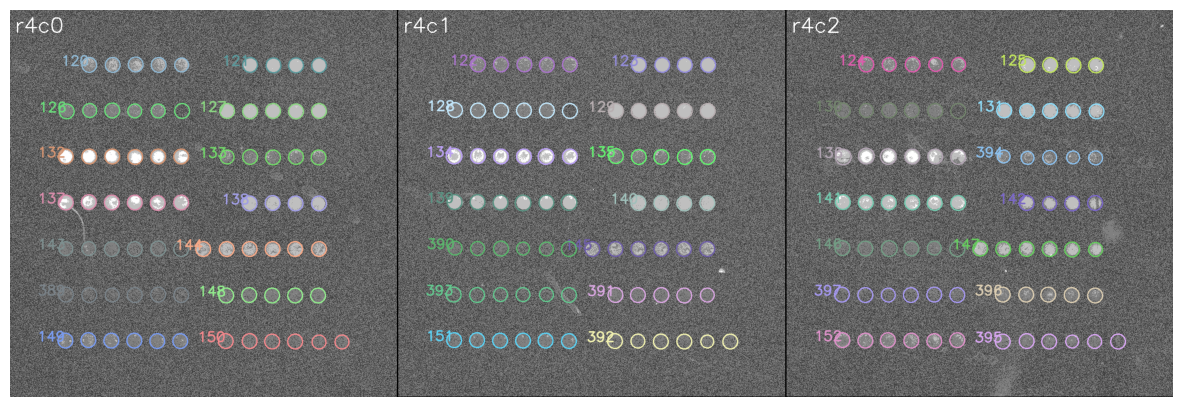

In [96]:
# row 4
r = 4
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0':[0,0],f'r{r}c1':[0,0],f'r{r}c2':[0,0],f'r{r}c3':[0,0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
        })


['r5c0', 'r5c1', 'r5c2']

 

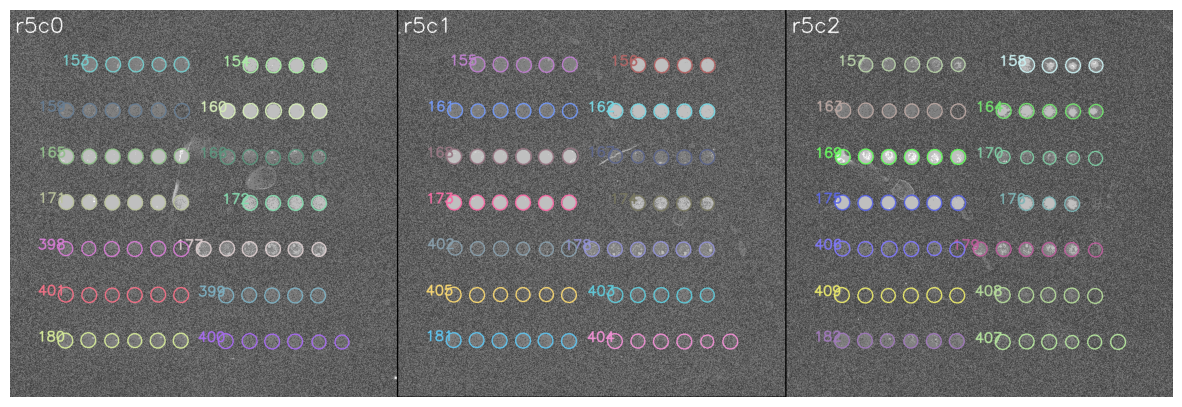

In [97]:
# row 5
r = 5
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        # move_whole_block_match={f'r{r}c0':[0,0],f'r{r}c1':[0,0],f'r{r}c2':[-45,10],f'r{r}c3':[0,0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
            176:['del spot-1',],
            # 179:['del spot-1']
        })


['r6c0', 'r6c1', 'r6c2']

 

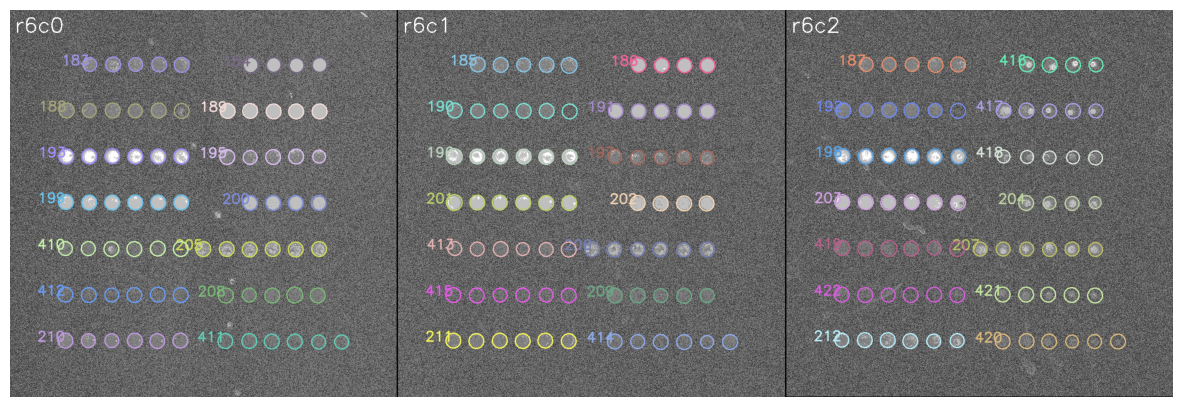

In [98]:
# row 6
r = 6
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0':[0,0],f'r{r}c1':[0,0],f'r{r}c2':[0,0],f'r{r}c3':[0,0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
             # 277:['del spot-1'], 276:['del spot-1'], 301:['del spot-1'], 308:['del spot-1'], 309:['del spot-1'], 287:['del spot-1'], 294:['del spot-1'], 300:['del spot-1'],
        })


['r7c0', 'r7c1', 'r7c2']

 

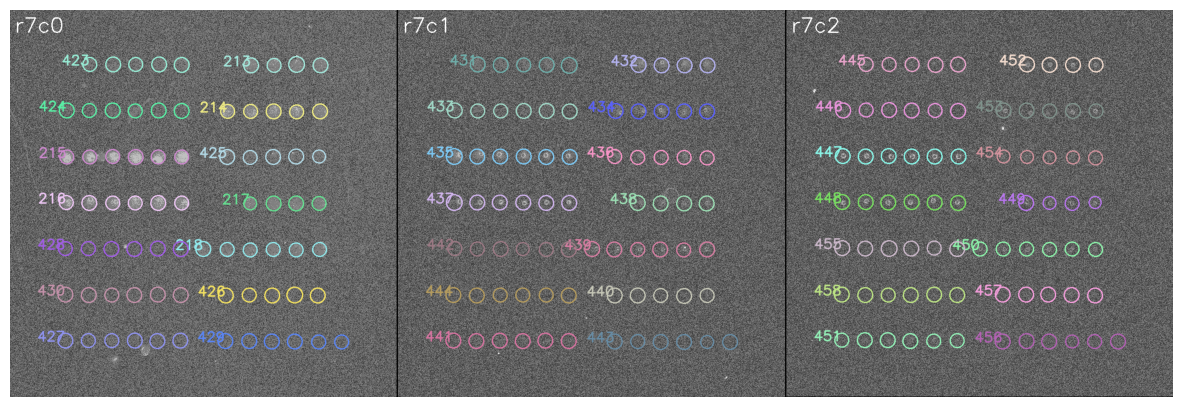

In [99]:
##### row 7
r = 7
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0':[0,0],f'r{r}c1':[0,5],f'r{r}c2':[-5,5],f'r{r}c3':[0,0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
        })


In [100]:
##### row 8
r = 8
if scan_data.assay == 'SD4':
    current_list = rows_names_list[r]
else:
    current_list = []

print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        # move_whole_block_match={f'r{r}c0': [-50, 0], f'r{r}c1': [-50, 0], f'r{r}c2': [-50, 0], f'r{r}c3': [-50, 0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
            386:['del'], 393:['del'], 402:['del'], 394:['del spot0'], 388:['move spot-1 10 r, 6 u']
        })


[]


In [101]:
##### row 9
r = 9
if scan_data.assay == 'SD4':
    current_list = rows_names_list[r]
else:
    current_list = print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0': [0, 0], f'r{r}c1': [0, 0], f'r{r}c2': [-2, 45], f'r{r}c3': [0, 0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
             403:['del'],
            # 404:['del spot6,4,2','move all 50 u'],
            404:['del'],
            420:['del'],
            405:['del'],
            # 409:['del'],
            # 411:['del spot0'],
            417:['del'],
        })


[]


In [102]:
##### row 10
r = 10
if scan_data.assay == 'SD4':
    current_list = rows_names_list[r]
else:
    current_list = []
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        # move_whole_block_match={f'r{r}c0': [-100, 0], f'r{r}c1': [-70, 0], f'r{r}c2': [-50, 0], f'r{r}c3': [-50, 0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
        })

[]


In [103]:
##### row 11
r = 11
if scan_data.assay == 'SD4':
    current_list = rows_names_list[r]
else:
    current_list = []
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0': [0, 0], f'r{r}c1': [0, 0], f'r{r}c2': [0, 0], f'r{r}c3': [0, 0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
        })

[]


In [104]:
# b11 = scan_data.get_block('r11c0')
# # b11.reset_block_start_end_coords((200,9900), [1200,11000], debug=False)
# # b11.add_cropped_images()
# b11.plot_block()
# b11.__dict__

In [105]:
##### row 12
r = 12
if scan_data.assay == 'SD4':
    current_list = rows_names_list[r]
else:
    current_list = []
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        # move_whole_block_match={f'r{r}c0': [-0, 0], f'r{r}c1': [-100, 0], f'r{r}c2': [-50, 0], f'r{r}c3': [-50, 0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
            # 759:['del'],755:['add 1 cluster below d=50'], 761:['add 1 cluster above d=50'],
            555:['del']
        })


[]


In [106]:
##### row 13
r = 13
if scan_data.assay == 'SD4':
    current_list = rows_names_list[r]
else:
    current_list = []
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        # move_whole_block_match={f'r{r}c0': [-0, 0], f'r{r}c1': [-100, 0], f'r{r}c2': [-50, 0], f'r{r}c3': [-50, 0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
            569:['del'], 567:['del spot3,2,1,0'], 581:['move spot-1 10 l']
        })


[]


In [107]:
##### row 14
r = 14
if scan_data.assay == 'SD4':
    current_list = rows_names_list[r]
else:
    current_list = []
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        # move_whole_block_match={f'r{r}c0': [-0, 0], f'r{r}c1': [-100, 0], f'r{r}c2': [-50, 0], f'r{r}c3': [-50, 0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
            615:['del spot11,9,7,5,3,1,0']
        })


[]


In [108]:
# scan_data.get_block('r15c0').update_block_start_end_from_clusters_min_max()

In [109]:
##### row 15
r = 15
if scan_data.assay == 'SD4':
    current_list = rows_names_list[r]
else:
    current_list = []
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        # move_whole_block_match={f'r{r}c0': [-50, -100], f'r{r}c1': [0, -10], f'r{r}c2': [0, 0], f'r{r}c3': [0, 0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
            # 780:['del spot11,9,7,5,3,1,0']
        })


[]


In [110]:
path, input_file_name

('/Users/afarinaqs/Library/CloudStorage/Box-Box/Home Folder aa714/Private/BME LAB/Afi/OOD Detection/Data/Ag Test',
 '05062025_P0428_OF_first_slide_N5')

In [111]:
ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)


In [112]:
## DOSE RESPONSE
## Additional test info and labeling
# scan_data = ScanDataObj.get_scan_data(file_name=input_file_name)
# assuming scan_data.assay =='SD4':
# curve_num_points = 7
# num_rep = 3
# num_blank_rows_at_bottom = 1
#
# start_Ag_conc = 250
# dilution_factor = 2

# if curve_num_points == 4:
#     rows_info = {
#         'r0,2,4,6': {'Ag': 'WT'},
#         'r1,3,5,7': {'Ag': 'WT'},
#         'r8,10,12,14': {'Ag': 'Omicron'},
#         'r9,11,13,15': {'Ag': 'Omicron'},
#     }
#     cols_info = {
#         'col0': {'dAb': '34@1.5'},
#         'col1': {'dAb': '35@1.5'},
#         'col2': {'dAb': '34@1'},
#         'col3': {'dAb': '35@1'},
#     }
# else:
#     rows_info, cols_info = {}, {}

#------
# blocks_info = {}
# for rows_ids, ag_dict in rows_info.items():
#     r_list = [int(x) for x in re.findall(r'\d+', rows_ids)]
#     if len(r_list) != curve_num_points:
#         print('WTF!!!')
#
#     for col, dAb_dict in cols_info.items():
#         c = int(re.findall(r'\d+', col)[0])
#
#         point_counter = 0
#         for r in r_list:
#             block_id = f'r{r}c{c}'
#             block = scan_data.get_block(block_id)
#             block.dAb_label = dAb_dict['dAb']
#             block.target = ag_dict['Ag']
#             block.Ag_conc = start_Ag_conc / (dilution_factor ** point_counter)
#             block.add_names_to_clusters(debug=1)
#             print(f'{block.block_id} - {block.target}@{block.Ag_conc} - {block.dAb_label}')
#             point_counter += 1

# def add_labels(assay_info_dict,debug=False):
#     blank_rows = [scan_data.block_nrow - x - 1 for x in range(num_blank_rows_at_bottom)]
#     CommonFunctions.debug_report(f'blank_rows are {blank_rows}',debug)
#     for start_block_id, cond_dict in assay_info_dict.items():
#         start_block = scan_data.get_block(start_block_id)
#
#         for n in range(1,curve_num_points):
#             new_r = start_block.row_number + n
#             new_block = scan_data.get_block(f'r{new_r}c{start_block.col_number}')
#             new_block.dAb_label = cond_dict['dAb']
#             new_block.target = cond_dict['Ag']
#             new_block.Ag_conc = start_Ag_conc / dilution_factor ** n if new_r not in blank_rows else 0
#             new_block.add_names_to_clusters(debug=debug)
#             print(f'\t{new_block.block_id} - {new_block.target}@{new_block.Ag_conc}')
#
# add_labels(assay_info_dict=assay_info, debug=0)



In [113]:
# EXPERIMENT #1: Screening with secondary antibodies
scan_data = ScanDataObj.get_scan_data(file_name=input_file_name)

scan_data.cAb_names = ['JN','OX','EG','gamma','Delta_o','Beta_o','BA','kappa','Omicron_o','Eta','Omicron','Delta','WT','Beta'] # row by row, left to right

row_labels = ['CovAb1','CovAb31','CovAb11','CovAb56','CovAb58','CovAb69','CovAb70','Blank',]
for r in range(8):
    row_label = row_labels[r]
    for c in range(3):
        block_id = f'r{r}c{c}'
        block = scan_data.get_block(block_id)
        block.dAb_label = row_label
        block.target = 'NA'
        block.Ag_conc = 500
        block.add_names_to_clusters(debug=0)
        print(f'{block.block_id} - {block.target}@{block.Ag_conc} - {block.dAb_label}')



r0c0 - NA@500 - CovAb1
r0c1 - NA@500 - CovAb1
r0c2 - NA@500 - CovAb1
r1c0 - NA@500 - CovAb31
r1c1 - NA@500 - CovAb31
r1c2 - NA@500 - CovAb31
r2c0 - NA@500 - CovAb11
r2c1 - NA@500 - CovAb11
r2c2 - NA@500 - CovAb11
r3c0 - NA@500 - CovAb56
r3c1 - NA@500 - CovAb56
r3c2 - NA@500 - CovAb56
r4c0 - NA@500 - CovAb58
r4c1 - NA@500 - CovAb58
r4c2 - NA@500 - CovAb58
r5c0 - NA@500 - CovAb69
r5c1 - NA@500 - CovAb69
r5c2 - NA@500 - CovAb69
r6c0 - NA@500 - CovAb70
r6c1 - NA@500 - CovAb70
r6c2 - NA@500 - CovAb70
r7c0 - NA@500 - Blank
r7c1 - NA@500 - Blank
r7c2 - NA@500 - Blank


In [114]:
# scan_data.get_block('r0c0').plot_block(description='full_report')


In [115]:
# ClassesFunctions.save_dicts_in_pickle(path=path)

In [116]:
# scan_data.get_block('r0c0').full_report()
# print(scan_data.get_block('r0c0').full_report(return_str=1))
# scan_data.get_block('r1c0').plot_block(description='cAb_names')

In [118]:
out_dfs = []
sigma1 = 2
sigma2 = 1.7

# this one goes row by row:
for r in range(scan_data.block_nrow):
    block_ids_list = rows_names_list[r]
    out_df, counts = ClassesFunctions.measure_signal_of_blocks(
        block_ids_list=block_ids_list,
        file_name=input_file_name,
        sigma1=sigma1,
        sigma2=sigma2,
        fg_inc_pixels=1,
        margin_pixels=3,
        bg_r=6,
        debug=0,
        debug_blocks_ids=[''],
        plot_images=0,
    )
    out_dfs.append(out_df)
#     total_counts += counts1



r0c0 ....
r0c1 ....
r0c2 ....
delete1: 86 (0.0336%), delete2: 10412 (4.0619%) -> total delete: 4.10%
r1c0 ....
r1c1 ....
r1c2 ....
delete1: 6183 (2.5313%), delete2: 10921 (4.4710%) -> total delete: 7.00%
r2c0 ....
r2c1 ....
r2c2 ....
delete1: 4903 (2.0325%), delete2: 23776 (9.8560%) -> total delete: 11.89%
r3c0 ....
r3c1 ....
r3c2 ....
delete1: 4305 (1.8133%), delete2: 20450 (8.6139%) -> total delete: 10.43%
r4c0 ....
r4c1 ....
r4c2 ....
delete1: 6223 (2.5755%), delete2: 6559 (2.7145%) -> total delete: 5.29%
r5c0 ....
r5c1 ....
r5c2 ....
delete1: 6834 (2.8335%), delete2: 21837 (9.0539%) -> total delete: 11.89%
r6c0 ....
r6c1 ....
r6c2 ....
delete1: 10252 (4.1027%), delete2: 3591 (1.4371%) -> total delete: 5.54%
r7c0 ....
r7c1 ....
r7c2 ....
delete1: 2281 (0.9272%), delete2: 28582 (11.6181%) -> total delete: 12.55%


In [ ]:
path

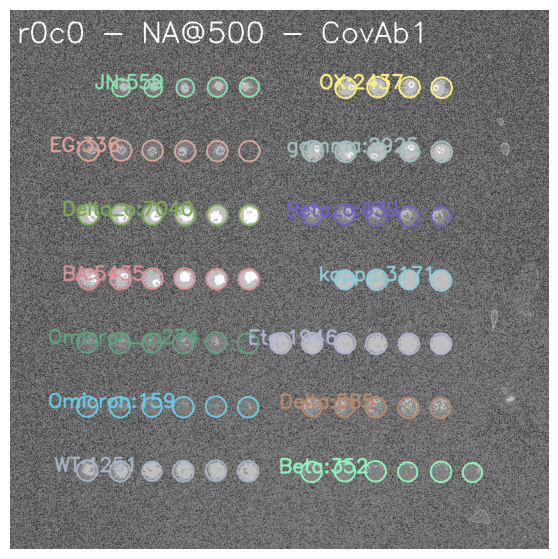

Block_ID  Col  Row  Ag_Conc. target dAb_name cAb_name  Cluster_ID  \
0       r0c0    0    0     500.0     NA   CovAb1       JN           0   
1       r0c0    0    0     500.0     NA   CovAb1       JN           0   
2       r0c0    0    0     500.0     NA   CovAb1       JN           0   
3       r0c0    0    0     500.0     NA   CovAb1       JN           0   
4       r0c0    0    0     500.0     NA   CovAb1       JN           0   
..       ...  ...  ...       ...    ...      ...      ...         ...   
223     r0c2    2    0     500.0     NA   CovAb1     Beta         350   
224     r0c2    2    0     500.0     NA   CovAb1     Beta         350   
225     r0c2    2    0     500.0     NA   CovAb1     Beta         350   
226     r0c2    2    0     500.0     NA   CovAb1     Beta         350   
227     r0c2    2    0     500.0     NA   CovAb1     Beta         350   

     Spot_Index    F    B  F_B  F_B_PostProcess  Average_F_B_PostProcess  
0             0  640  125  515       515.946403               559.888759  
1             1  653  126  527       527.032440               559.888759  
2             2  729  126  603       603.638928               559.888759  
3             3  718  126  592       592.937265               559.888759  
4             4  984  126  858              NaN               559.888759  
..          ...  ...  ...  ...              ...                      ...  
223           1  436   98  338       338.729190               257.845275  
224           2  345   97  248       248.071032               257.845275  
225           3  364   97  267       267.526976               257.845275  
226           4  325   97  228       228.205327               257.845275  
227           5  304   98  206       206.693852               257.845275  

[228 rows x 14 columns]

In [119]:
# wanna see everything for Z in rXcY:
cAb = 'Delta_0'
row_id = 0
block_id = f'r{row_id}c0'
df1 = out_dfs[row_id]
df = df1[(df1['cAb_name']==cAb) & (df1['Block_ID']==block_id)]
scan_data.get_block(block_id).plot_block(description='full_report', crop_to_mask=1)
# print(df)
df1

In [ ]:
# formated_path

In [120]:
dosave=True
formated_path = f'{path}/{input_file_name}_genepix_level'

if dosave:
    ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    intensities_df = pd.concat(out_dfs, ignore_index=True)
    with open(formated_path+'.pickle', 'wb') as file:
        pickle.dump(intensities_df, file)

    intensities_writer = pd.ExcelWriter(formated_path + '.xlsx')
    intensities_df.to_excel(intensities_writer, index=True)
    intensities_writer.close()


    print(f'saved intensities_df {intensities_df.shape}.')

else:
    with open(formated_path+'.pickle', 'rb') as file:
        intensities_df = pickle.load(file)
        print(f'loaded intensities_df {intensities_df.shape}')


intensities_df

saved intensities_df (1823, 14).


Block_ID  Col  Row  Ag_Conc. target dAb_name cAb_name  Cluster_ID  \
0        r0c0    0    0     500.0     NA   CovAb1       JN           0   
1        r0c0    0    0     500.0     NA   CovAb1       JN           0   
2        r0c0    0    0     500.0     NA   CovAb1       JN           0   
3        r0c0    0    0     500.0     NA   CovAb1       JN           0   
4        r0c0    0    0     500.0     NA   CovAb1       JN           0   
...       ...  ...  ...       ...    ...      ...      ...         ...   
1818     r7c2    2    7     500.0     NA    Blank     Beta         456   
1819     r7c2    2    7     500.0     NA    Blank     Beta         456   
1820     r7c2    2    7     500.0     NA    Blank     Beta         456   
1821     r7c2    2    7     500.0     NA    Blank     Beta         456   
1822     r7c2    2    7     500.0     NA    Blank     Beta         456   

      Spot_Index    F    B  F_B  F_B_PostProcess  Average_F_B_PostProcess  
0              0  640  125  515       515.946403               559.888759  
1              1  653  126  527       527.032440               559.888759  
2              2  729  126  603       603.638928               559.888759  
3              3  718  126  592       592.937265               559.888759  
4              4  984  126  858              NaN               559.888759  
...          ...  ...  ...  ...              ...                      ...  
1818           1  123   97   26        26.365150                25.136457  
1819           2  120   96   24        24.895671                25.136457  
1820           3  116   95   21        21.720733                25.136457  
1821           4  123   96   27        27.983689                25.136457  
1822           5  123   96   27        27.798002                25.136457  

[1823 rows x 14 columns]

In [121]:
intensities_df[intensities_df['cAb_name']=='JN']

Block_ID  Col  Row  Ag_Conc. target dAb_name cAb_name  Cluster_ID  \
0        r0c0    0    0     500.0     NA   CovAb1       JN           0   
1        r0c0    0    0     500.0     NA   CovAb1       JN           0   
2        r0c0    0    0     500.0     NA   CovAb1       JN           0   
3        r0c0    0    0     500.0     NA   CovAb1       JN           0   
4        r0c0    0    0     500.0     NA   CovAb1       JN           0   
...       ...  ...  ...       ...    ...      ...      ...         ...   
1747     r7c2    2    7     500.0     NA    Blank       JN         445   
1748     r7c2    2    7     500.0     NA    Blank       JN         445   
1749     r7c2    2    7     500.0     NA    Blank       JN         445   
1750     r7c2    2    7     500.0     NA    Blank       JN         445   
1751     r7c2    2    7     500.0     NA    Blank       JN         445   

      Spot_Index    F    B  F_B  F_B_PostProcess  Average_F_B_PostProcess  
0              0  640  125  515       515.946403               559.888759  
1              1  653  126  527       527.032440               559.888759  
2              2  729  126  603       603.638928               559.888759  
3              3  718  126  592       592.937265               559.888759  
4              4  984  126  858              NaN               559.888759  
...          ...  ...  ...  ...              ...                      ...  
1747           0  129   94   35        35.525721                31.884323  
1748           1  122   95   27        27.268507                31.884323  
1749           2  138   94   44              NaN                31.884323  
1750           3  124   94   30        30.129301                31.884323  
1751           4  129   95   34        34.613762                31.884323  

[119 rows x 14 columns]

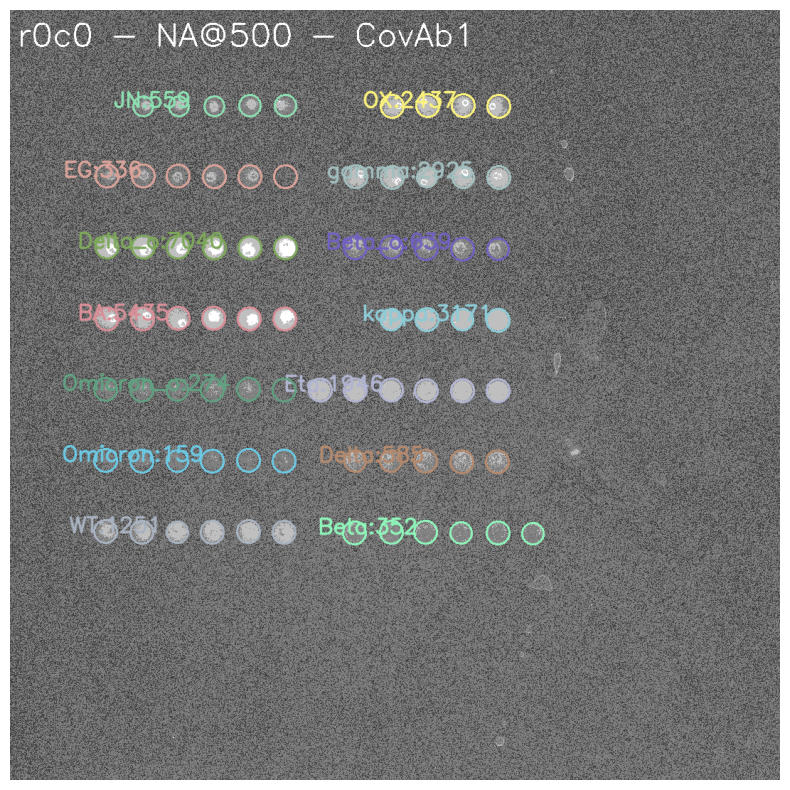

In [122]:
scan_data.get_block('r0c0').plot_block(description='full_report', fig_size=[10,10])


In [132]:
ag_test = 1
grouped = intensities_df.groupby(['Block_ID', 'Row', 'Col', 'cAb_name', 'dAb_name'])['Average_F_B_PostProcess'].mean().reset_index()
grouped = grouped.sort_values(by=['Row', 'Col'])
grouped['abs_rep'] = grouped.apply(lambda x: f"{x['dAb_name']}" +
                                           ("" if x['Col'] == 0 else "_1" if x['Col'] == 1 else "_2"), axis=1)

grouped[['COV_Ab', 'SEC_Ab']] = grouped['dAb_name'].str.extract(r'([^_]+)_([^_]+)')

grouped[grouped['cAb_name']=='JN']
# grouped.columns



Block_ID  Row  Col cAb_name dAb_name  Average_F_B_PostProcess    abs_rep  \
7       r0c0    0    0       JN   CovAb1               559.888759     CovAb1   
21      r0c1    0    1       JN   CovAb1               405.468476   CovAb1_1   
35      r0c2    0    2       JN   CovAb1               504.395477   CovAb1_2   
49      r1c0    1    0       JN  CovAb31               457.967021    CovAb31   
63      r1c1    1    1       JN  CovAb31               462.685337  CovAb31_1   
77      r1c2    1    2       JN  CovAb31               367.486890  CovAb31_2   
91      r2c0    2    0       JN  CovAb11               805.675496    CovAb11   
105     r2c1    2    1       JN  CovAb11               782.556881  CovAb11_1   
119     r2c2    2    2       JN  CovAb11               478.797051  CovAb11_2   
133     r3c0    3    0       JN  CovAb56               475.816901    CovAb56   
147     r3c1    3    1       JN  CovAb56               429.847114  CovAb56_1   
161     r3c2    3    2       JN  CovAb56               382.835516  CovAb56_2   
175     r4c0    4    0       JN  CovAb58               695.546611    CovAb58   
189     r4c1    4    1       JN  CovAb58               483.704994  CovAb58_1   
203     r4c2    4    2       JN  CovAb58               548.537875  CovAb58_2   
217     r5c0    5    0       JN  CovAb69               346.927401    CovAb69   
231     r5c1    5    1       JN  CovAb69               325.590178  CovAb69_1   
245     r5c2    5    2       JN  CovAb69               383.186667  CovAb69_2   
259     r6c0    6    0       JN  CovAb70               447.321629    CovAb70   
273     r6c1    6    1       JN  CovAb70               423.504200  CovAb70_1   
287     r6c2    6    2       JN  CovAb70               956.866508  CovAb70_2   
301     r7c0    7    0       JN    Blank                89.316210      Blank   
315     r7c1    7    1       JN    Blank                73.212539    Blank_1   
329     r7c2    7    2       JN    Blank                31.884323    Blank_2   

    COV_Ab SEC_Ab  
7     <NA>   <NA>  
21    <NA>   <NA>  
35    <NA>   <NA>  
49    <NA>   <NA>  
63    <NA>   <NA>  
77    <NA>   <NA>  
91    <NA>   <NA>  
105   <NA>   <NA>  
119   <NA>   <NA>  
133   <NA>   <NA>  
147   <NA>   <NA>  
161   <NA>   <NA>  
175   <NA>   <NA>  
189   <NA>   <NA>  
203   <NA>   <NA>  
217   <NA>   <NA>  
231   <NA>   <NA>  
245   <NA>   <NA>  
259   <NA>   <NA>  
273   <NA>   <NA>  
287   <NA>   <NA>  
301   <NA>   <NA>  
315   <NA>   <NA>  
329   <NA>   <NA>

In [133]:
# import matplotlib.pyplot as plt
# import seaborn as sns
#
# ags = sorted(grouped['cAb_name'].unique())
# n_rows, n_cols = 3, 5
#
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3), constrained_layout=True)
#
# for ax, ag_val in zip(axes.flat, ags):
#     subset = grouped[grouped['cAb_name'] == ag_val]
#     pivot = subset.groupby(['COV_Ab', 'SEC_Ab'])['Average_F_B_PostProcess'].mean().unstack()/1000
#
#     sns.heatmap(pivot, annot=True, cmap='crest',ax=ax, cbar=False)
#     ax.set_title(f'Ag: {ag_val}')
#     ax.set_xlabel('SEC_Ab')
#     ax.set_ylabel('COV_Ab')
#
# # Hide unused subplots if there are any
# for ax in axes.flat[len(ags):]:
#     ax.axis('off')
#
# plt.show()


In [134]:
# import matplotlib.pyplot as plt
# import seaborn as sns
#
# pivot = grouped.groupby(['COV_Ab', 'SEC_Ab'])['Average_F_B_PostProcess'].mean().unstack()/1000
#
# plt.figure(figsize=(3,4))
# sns.heatmap(pivot, annot=True, cmap="viridis")
# plt.title(f'Avg Heatmap')
# plt.xlabel('SEC_Ab')
# plt.ylabel('COV_Ab')
# plt.tight_layout()
# plt.show()
#


In [135]:
sheets_df = {}
for Ag, group in grouped.groupby('cAb_name'):
    print(Ag)
    sheet_name = f"{Ag}"
    filtered_group = group.copy()
    # print(filtered_group.columns)
    unique_reps = sorted(filtered_group['abs_rep'].unique())
    # print(f'unique_reps: {unique_reps}')
    filtered_group = filtered_group[filtered_group['abs_rep'].isin(unique_reps)]
    filtered_group.insert(0, 'Label', sheet_name)
    pivot_df = filtered_group.pivot_table(index=['Label'], columns=['abs_rep'],
                                 values='Average_F_B_PostProcess').sort_values(by=['Label'],ascending=False)
    pivot_df.reset_index(inplace=True)
    sheets_df[sheet_name] = pivot_df

sheets_df['JN']

BA
Beta
Beta_o
Delta
Delta_o
EG
Eta
JN
OX
Omicron
Omicron_o
WT
gamma
kappa


abs_rep Label     Blank    Blank_1    Blank_2      CovAb1     CovAb11  \
0          JN  89.31621  73.212539  31.884323  559.888759  805.675496   

abs_rep   CovAb11_1   CovAb11_2    CovAb1_1    CovAb1_2  ...   CovAb56_2  \
0        782.556881  478.797051  405.468476  504.395477  ...  382.835516   

abs_rep     CovAb58   CovAb58_1   CovAb58_2     CovAb69   CovAb69_1  \
0        695.546611  483.704994  548.537875  346.927401  325.590178   

abs_rep   CovAb69_2     CovAb70  CovAb70_1   CovAb70_2  
0        383.186667  447.321629   423.5042  956.866508  

[1 rows x 25 columns]

In [136]:
# grouped = intensities_df.groupby(['Ag_Conc.', 'Block_ID', 'Row', 'Col', 'target', 'cAb_name', 'dAb_name'])['Average_F_B_PostProcess'].mean().reset_index()
# grouped = grouped.sort_values(by=['Row', 'Col'])
#
# # if num_rep == 2 and curve_num_points==4:
# #     grouped['dAb_cAb_rep'] = grouped.apply(lambda x: f"{x['dAb_name']}_{x['cAb_name']}" +
# #                                            ("" if x['Row'] % 2 == 0 else "_2"), axis=1)
# # if ag_test:
# #     grouped['ab_pair'] = grouped.apply(lambda x: f"{x['dAb_name']}_{x['cAb_name']}" +
# #                                            ("" if x['Row'] % 2 == 0 else "_2"), axis=1)
#
#
# grouped[grouped['cAb_name']=='JN']
#


In [138]:
# grouped.groupby(['dAb_name', 'target']).head()

In [141]:
# sheets_df = {}
# for (dAb, target), group in grouped.groupby(['dAb_name']):
#     sheet_name = f"{dAb}_{target}"
#     filtered_group = group.copy()
#     print(filtered_group.columns)
#     unique_reps = sorted(filtered_group['dAb_cAb_rep'].unique())
#     filtered_group = filtered_group[filtered_group['dAb_cAb_rep'].isin(unique_reps)]
#     filtered_group.insert(0, 'Label', sheet_name)
#     pivot_df = filtered_group.pivot_table(index=['Label','Ag_Conc.'], columns=['dAb_cAb_rep'],
#                                  values='Average_F_B_PostProcess').sort_values(by=['Label','Ag_Conc.'],ascending=False)
#     pivot_df.reset_index(inplace=True)
#     sheets_df[sheet_name] = pivot_df
#
# # sheets_df['34@1.5_WT']

In [142]:
ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

formated_path = f'{path}/{input_file_name}_summary'
summary_writer = pd.ExcelWriter(formated_path + '.xlsx')

for sheet_name, sheet_df in sheets_df.items():
    sheet_df.to_excel(summary_writer, sheet_name=sheet_name, index=False)
summary_writer.close()

with open(formated_path+'.pickle', 'wb') as file:
    pickle.dump(sheets_df, file)


In [144]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
#
# def plot_dose_response_with_error(results_df):
#     # Extract base names by removing "_2" suffix if present
#     results_df['base_dAb_cAb_rep'] = results_df['dAb_cAb_rep'].str.replace('_2$', '', regex=True)
#
#     # Group by target, Ag_Conc., and base_dAb_cAb_rep to compute mean and std
#     grouped_df = results_df.groupby(['target', 'Ag_Conc.', 'base_dAb_cAb_rep'])['Average_F_B_PostProcess'].agg(['mean', 'std']).reset_index()
#
#     # Plot each unique target
#     plt.figure(figsize=(8, 6))
#     sns.lineplot(data=grouped_df, x='Ag_Conc.', y='mean', hue='base_dAb_cAb_rep', style='target', marker='o')
#     plt.errorbar(grouped_df['Ag_Conc.'], grouped_df['mean'], yerr=grouped_df['std'], fmt='o', alpha=0.5)
#
#     plt.xscale('log')  # Log scale if needed
#     plt.xlabel("Antigen Concentration")
#     plt.ylabel("Response (Fluorescence)")
#     plt.title("Dose-Response Curves with Error Bars")
#     plt.legend(title="dAb_cAb_rep")
#     plt.show()
#
# # Example usage:
# plot_dose_response_with_error(group)


In [ ]:
group